# CaptureNet-Deep: Demo Capture Detection

This notebook demonstrates end-to-end inference on a synthetic 60,000-point nanopore current trace using the pretrained **CaptureNet-Deep** model.

**What you'll do:**
1. Import dependencies
2. Load demo data from `data/`
3. Load a pretrained checkpoint from `models/`
4. Run windowed inference
5. Merge and visualize predicted capture intervals

> Requires: `src/model.py`, `src/inference.py`, `models/best-model.ckpt`, and the demo files in `data/`.


In [2]:
# 1) Imports
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import sys

# Add repo root to path so `src/` is importable when running from /examples
repo_root = Path('..').resolve()
sys.path.insert(0, str(repo_root))

from src.inference import load_checkpoint, window_predict, merge_windows

In [3]:
# 2) Load demo data
signal_path = repo_root / 'data' / 'demo_signal.csv'
labels_path = repo_root / 'data' / 'demo_labels.json'

sig = pd.read_csv(signal_path)['current'].to_numpy()
labels = json.load(open(labels_path))  # list of {start, end}
len(sig), labels[:3]


(60000,
 [{'start': 7283, 'end': 11488},
  {'start': 24096, 'end': 29887},
  {'start': 42117, 'end': 45929}])

In [4]:
# 2.5) loading checkpoint (handle naming mismatch)
from src.model import CaptureNetDeep, CaptureLightningModule

def load_checkpoint_flexible(ckpt_path, dropout=0.739, device="cpu"):
    base = CaptureNetDeep(dropout=dropout)
    try:
        # Try normal loading first
        lit = CaptureLightningModule.load_from_checkpoint(ckpt_path, model=base, map_location=device)
    except RuntimeError:
        # If that fails, load with strict=False to handle naming mismatches
        lit = CaptureLightningModule.load_from_checkpoint(ckpt_path, model=base, map_location=device, strict=False)
    return lit.model.to(device).eval(), getattr(lit.hparams, "cutoff", 0.524)

In [5]:
# 3) Load pretrained model
ckpt_path = repo_root / 'models' / 'best-model.ckpt'
model, cutoff = load_checkpoint_flexible(str(ckpt_path))
cutoff

C:\Users\annab\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\core\saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['crit.pos_weight']
C:\Users\annab\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']


0.524

## Model Architecture

**CaptureNet-Deep** consists of two main components:

### 1. CaptureNetDeep (Core CNN)
- **Input**: 1D nanopore current signal (2000 samples)  
- **Architecture**: 5 Conv1D layers with BatchNorm and ReLU
  - Layer 1: 1→64 channels (kernel=5)
  - Layer 2: 64→128 channels (kernel=5)  
  - Layer 3: 128→256 channels (kernel=5)
  - Layer 4: 256→256 channels (kernel=3)
  - Layer 5: 256→256 channels (kernel=3)
- **Output**: Logits (raw predictions before sigmoid)

### 2. CaptureLightningModule (Training Wrapper)  
- **Framework**: PyTorch Lightning for automated training
- **Loss**: BCEWithLogitsLoss for binary classification
- **Optimizer**: AdamW with learning rate scheduling
- **Metrics**: Automatic logging of loss and accuracy

In [6]:
# 4) Run inference (windowed predictions)
window_size = 2000
step_size = 2200
pred_labels, spans = window_predict(sig, model, window_size=window_size, step_size=step_size, cutoff=cutoff)
intervals = merge_windows(pred_labels, spans)
intervals[:3]


[[6600, 10800], [24200, 30600], [41800, 46000]]

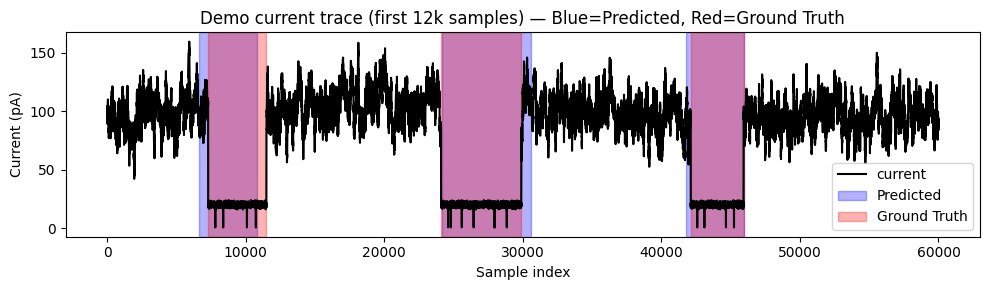

In [10]:
# 5) Plot samples with predicted vs. ground-truth intervals
start, end = 0, len(sig)
plt.figure(figsize=(10, 3))
plt.plot(np.arange(start, end), sig[start:end], label='current', color='black')

# shade predicted intervals overlapping the shown segment (blue)
for s, e in intervals:
    a, b = max(s, start), min(e, end)
    if a < b:
        plt.axvspan(a - start, b - start, alpha=0.3, color='blue', label='Predicted' if s == intervals[0][0] else "")

# shade ground-truth intervals (red)
for item in labels:
    s, e = int(item['start']), int(item['end'])
    a, b = max(s, start), min(e, end)
    if a < b:
        plt.axvspan(a - start, b - start, alpha=0.3, color='red', label='Ground Truth' if s == int(labels[0]['start']) else "")

plt.title('Demo current trace (first 12k samples) — Blue=Predicted, Red=Ground Truth')
plt.xlabel('Sample index')
plt.ylabel('Current (pA)')
plt.legend()
plt.tight_layout()
plt.show()

### Notes
- Intervals are returned in **sample indices** of the original (downsampled) signal space used by the model.
- The model outputs logits; in this demo we apply a sigmoid and threshold at `cutoff` from the checkpoint.
- The simple neighbor-smoothing pass removes isolated flips like `[0,1,0] → [0,0,0]`.
